In [1]:
from myAE import Manager
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
manager = Manager()
manager.prepare_data()

def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    loss = ll + kl
    return loss

manager.set_default_model(4, 2)

In [3]:
hist = manager.train_on_cpu(calc_loss, epochs=30)

Now, it is working on cpu.


100%|██████████| 30/30 [05:41<00:00, 11.38s/it]


In [4]:
# take 6,000 points on the 2D latent space
base_points = torch.randn([6000, 2])

# decode the base points
with torch.no_grad():
    generated_imgs = manager.model.get_submodule('decoder')(base_points)

print(generated_imgs.shape)

torch.Size([6000, 1, 28, 28])


In [5]:
indices = []
# find nearest sample for each generated image

from tqdm import tqdm

for img in tqdm(generated_imgs):
    # make 60000 copy of img
    pred = torch.stack([img] * 60000)

    x = manager.training_data
    loss = F.binary_cross_entropy(pred, x, reduction='none')
    loss = loss.sum(dim=[1, 2, 3])

    # find index of least loss sample
    min_idx = loss.argmin().item()
    indices.append(min_idx)

print(len(indices))

  0%|          | 0/6000 [00:00<?, ?it/s]

100%|██████████| 6000/6000 [17:10<00:00,  5.82it/s]

6000


In [6]:
# copy model and set optimizer
manager_2 = Manager()
manager_2.prepare_data()
manager_2.set_default_model(4, 2)

manager_2.model.load_state_dict(manager.model.state_dict())
manager_2.optimizer = torch.optim.Adam(manager_2.model.parameters())

In [7]:
def show_100_images(imgs):
    tmp = torch.zeros(28 * 10, 28 * 10)
    
    for row in range(10):
        for col, img in enumerate(imgs[row * 10:(row + 1) * 10]):
            tmp[row * 28:(row + 1) * 28, col * 28: (col + 1) * 28] = img.view(28, 28)

    plt.figure(figsize=(20, 20))
    plt.imshow(tmp, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

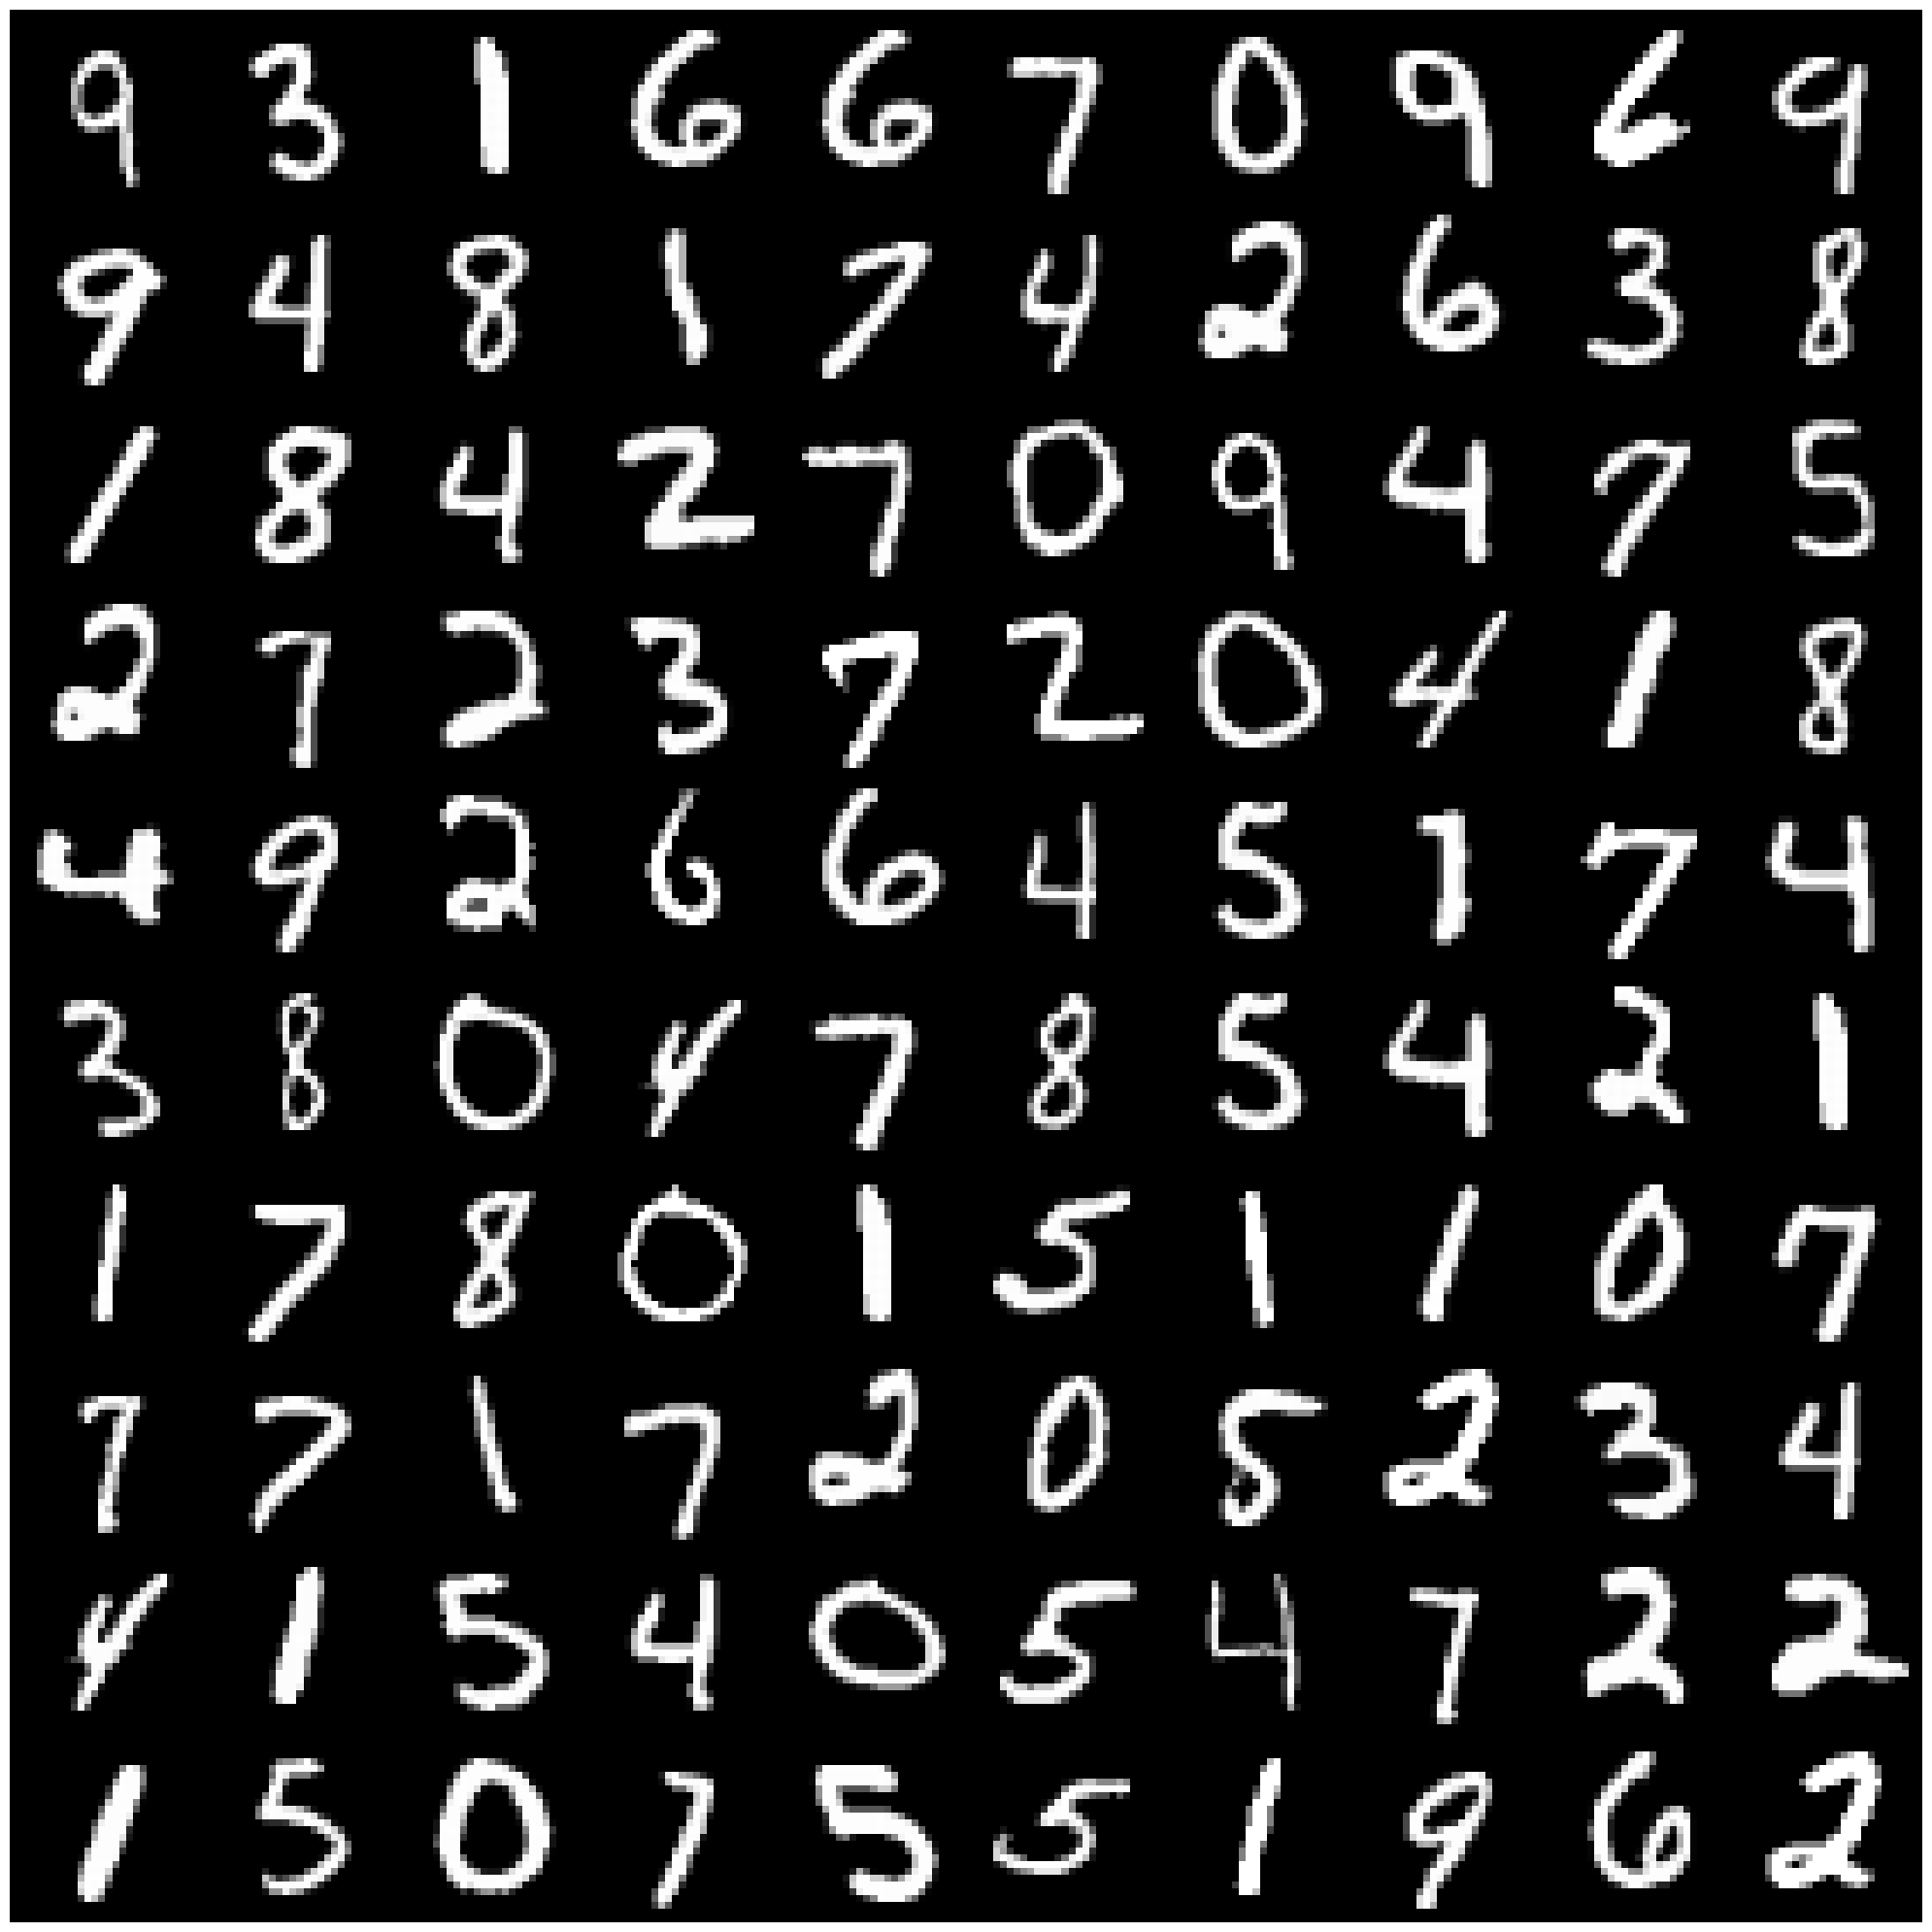

In [8]:
idx_tensor = torch.tensor(indices, dtype=torch.long)
show_100_images(manager.training_data[idx_tensor[:100]])

In [9]:
# set a new data loader
from torch.utils.data import Dataset, DataLoader

class TmpDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

manager_2.training_data = manager.training_data[idx_tensor]
manager_2.training_targets = manager.training_targets[idx_tensor]

manager_2.training_data_length = len(manager_2.training_data)

manager_2.train_dataloader = DataLoader(
    TmpDataset(manager_2.training_data, manager_2.training_targets), batch_size=128, shuffle=True
)

In [10]:
hist_2 = manager_2.train_on_cpu(calc_loss, epochs=30)

Now, it is working on cpu.


100%|██████████| 30/30 [00:19<00:00,  1.51it/s]


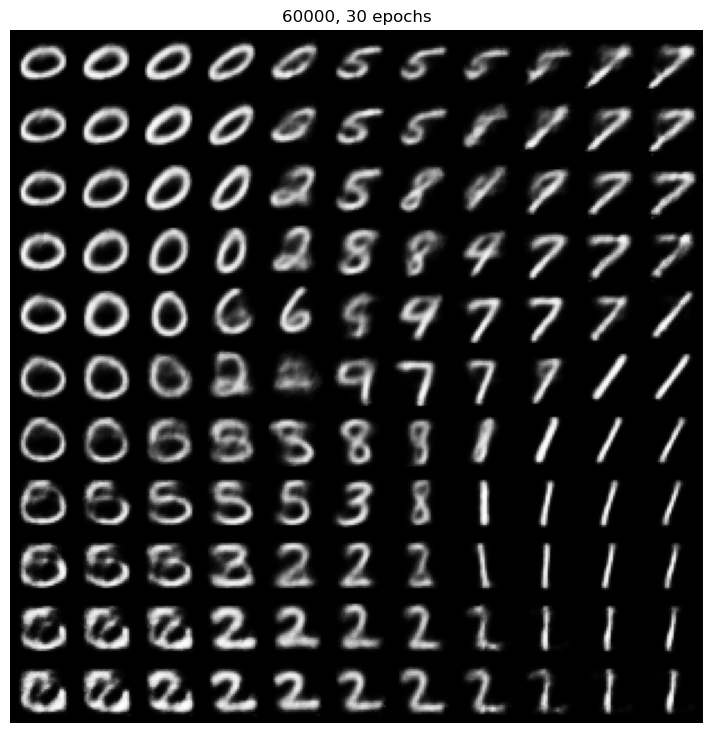

In [11]:
manager.plot_generated_images('60000, 30 epochs')

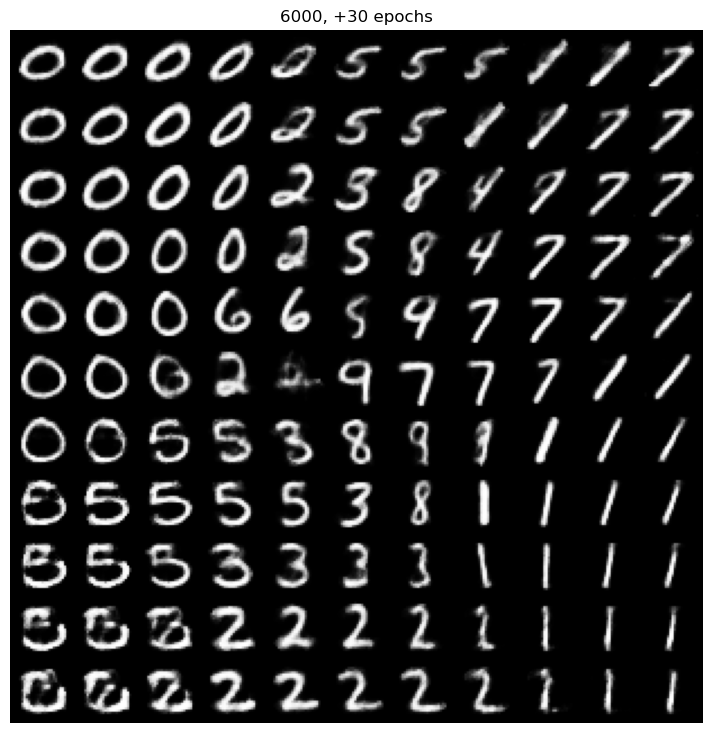

In [12]:
manager_2.plot_generated_images('6000, +30 epochs')

In [13]:
hist_1_2 = manager.train_on_cpu(calc_loss, epochs=30)

Now, it is working on cpu.


100%|██████████| 30/30 [05:33<00:00, 11.13s/it]


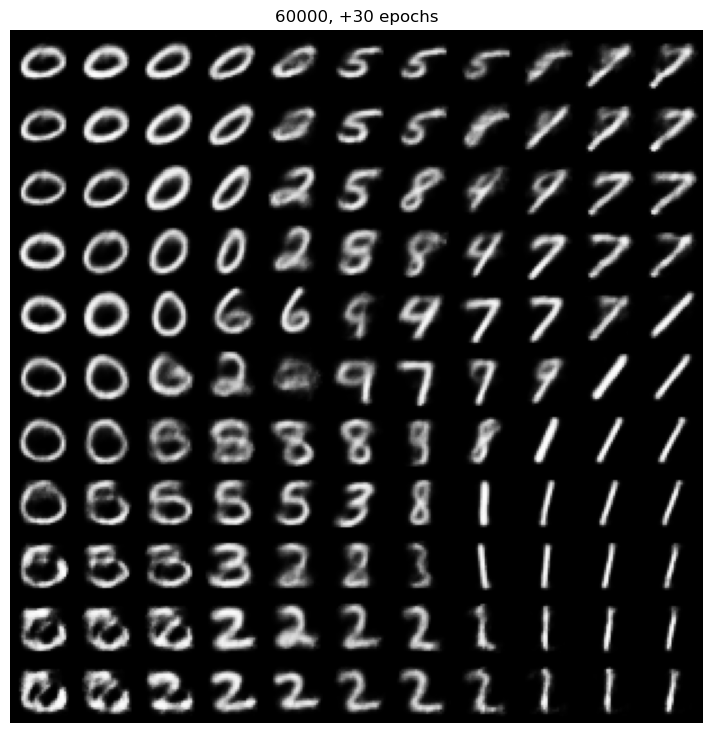

In [27]:
manager.plot_generated_images('60000, +30 epochs')

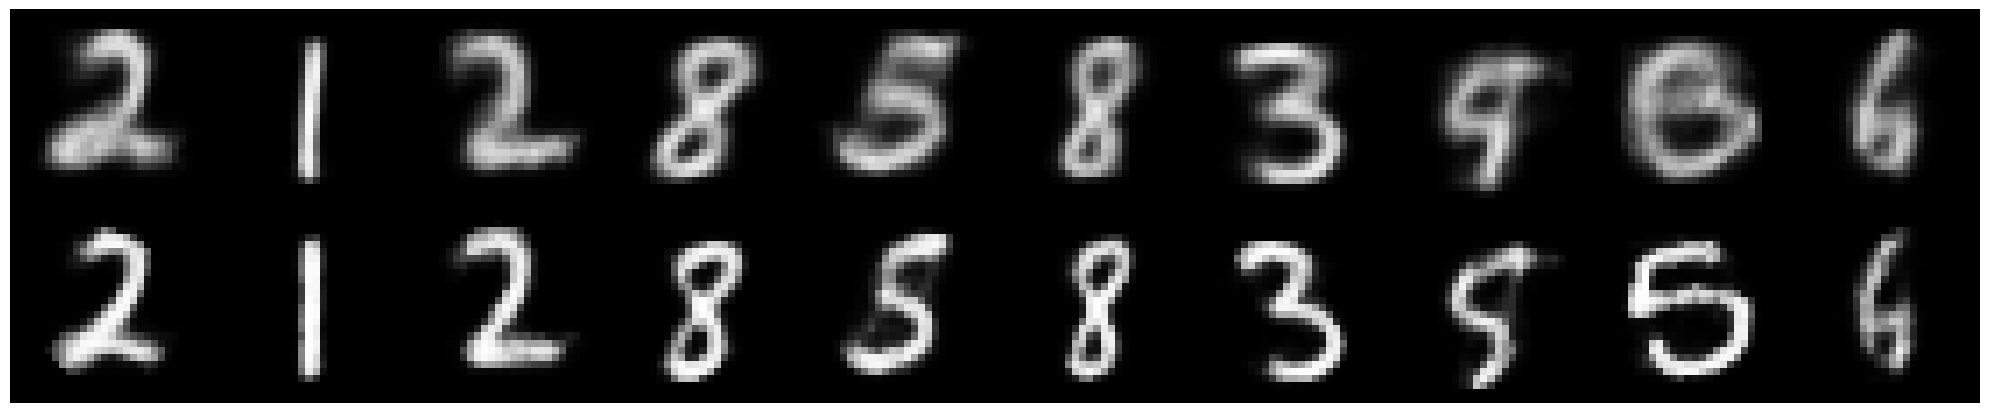

In [26]:
tmp_ten = torch.randn(10, 2)
with torch.no_grad():
    imgs_1 = manager.model.get_submodule('decoder')(tmp_ten)
    imgs_2 = manager_2.model.get_submodule('decoder')(tmp_ten)

def show_ten_images(ori_imgs, pred_imgs):
    tmp = torch.zeros(28 * 2, 28 * 10)

    for idx, img in enumerate(ori_imgs):
        tmp[:28, idx * 28: (idx + 1) * 28] = img.view(28, 28)

    for idx, img in enumerate(pred_imgs):
        tmp[28:28 * 2, idx * 28: (idx + 1) * 28] = img.view(28, 28)
    
    plt.figure(figsize=(20, 6))
    plt.imshow(tmp, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

show_ten_images(imgs_1, imgs_2)